In [1]:
% matplotlib inline

from sem_context import SemContext
from event_schemas import HybridRNN
from evaluation import train_online, plot_encoded_errors, plot_decoded_errors
from encoding_schemes import get_match, add_properties
import event_generation

import keras
import numpy as np

Using TensorFlow backend.


In [2]:
from coffeeshop_generator import enter_coffeeshop_fight
from poetry_generator import enter_coffeeshop_poetry

### Setup

In [3]:
dim = 100
import pickle
context = pickle.load(open("new_context.p", "rb" ))
segment_size = 100
eval_size = 30
num_segments = 101

### Train Event Schema

In [4]:
transition_model = HybridRNN(dim)
all_property_addition_errors = train_online(context, 'all_property_addition', segment_size, num_segments, eval_size, transition_model, enter_coffeeshop_fight)

In [5]:
from evaluation import train_online, plot_encoded_errors, plot_decoded_errors

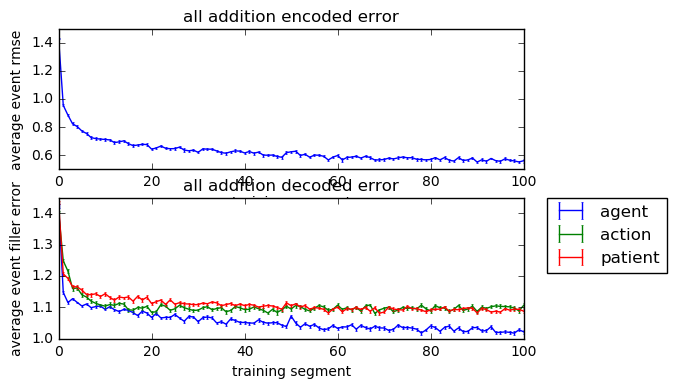

In [6]:
plot_encoded_errors("all addition", all_property_addition_errors)

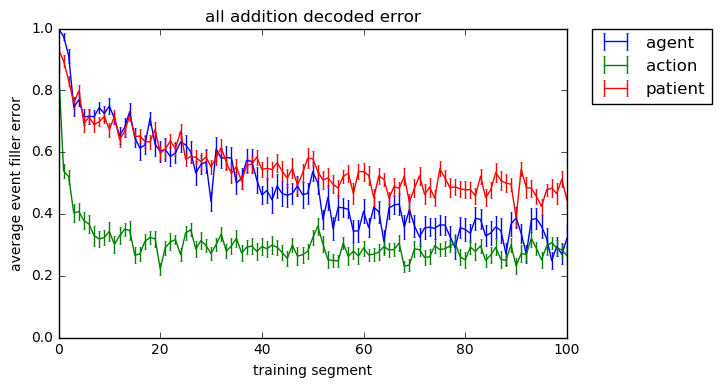

In [7]:
plot_decoded_errors("all addition", all_property_addition_errors)

### Evaluate Event Schema

In [9]:
events, fillers = event_generation.generate_evaluation_events(context, "all_property_addition", enter_coffeeshop_fight, num_events = 1, testing = True)

In [12]:
def compare(predicted, generating):
    action = list(add_properties(generating['action'], context))
    agent = list(add_properties(generating['agent'], context))
    patient = list(add_properties(generating['patient'], context))
    if list(predicted['action']) == action:
        if list(predicted['agent']) == agent and list(predicted['patient']) == patient:
            return 0
        if list(predicted['agent']) == patient and list(predicted['patient']) == agent:
            return 1
        if list(predicted['agent']) == agent:
            return 2
        if list(predicted['patient']) == patient:
            return 3
    if list(predicted['agent']) == agent and list(predicted['patient']) == patient:
        return 4
    if list(predicted['agent']) == agent:
        return 5
    if list(predicted['patient']) == patient:
        return 6
    return 7

In [15]:
error_types = {}
events, fillers = event_generation.generate_evaluation_events(context, "all_property_addition", enter_coffeeshop_fight, num_events = 50, testing = True)
for j in range(len(events)):
    event = events[j]
    filler = fillers[j]
    for i in range(1, len(event) - 1):
        last_id = filler[i - 1]['id']
        if (last_id) not in error_types.keys():
            error_types[last_id] = np.zeros(8)
        seen = event[0:i]
        prediction = transition_model.predict(seen) 
        prediction_fillers = get_match('all_property_addition', prediction, context, testing = True)
        index = compare(prediction_fillers, filler[i])
        error_types[last_id][index] += 1

In [16]:
error_types

{1: array([ 12.,   0.,  14.,   1.,   1.,  12.,   3.,   7.]),
 2: array([ 10.,   0.,   6.,   7.,   2.,   0.,   5.,   2.]),
 3: array([  1.,   0.,  10.,   0.,   0.,   0.,   0.,   7.]),
 4: array([ 3.,  0.,  2.,  5.,  1.,  1.,  6.,  0.]),
 5: array([ 7.,  0.,  2.,  4.,  9.,  5.,  1.,  3.]),
 6: array([ 6.,  0.,  2.,  0.,  2.,  5.,  1.,  3.]),
 7: array([ 2.,  0.,  2.,  1.,  3.,  3.,  3.,  1.]),
 8: array([ 5.,  0.,  0.,  8.,  0.,  0.,  0.,  1.]),
 9: array([ 1.,  1.,  1.,  1.,  1.,  3.,  2.,  4.]),
 10: array([ 4.,  0.,  5.,  2.,  1.,  6.,  1.,  2.]),
 11: array([ 3.,  0.,  1.,  4.,  1.,  2.,  0.,  6.]),
 12: array([ 2.,  0.,  3.,  0.,  3.,  0.,  0.,  3.]),
 13: array([ 2.,  0.,  9.,  1.,  1.,  4.,  0.,  5.]),
 14: array([ 13.,   0.,   4.,   0.,   0.,   9.,   0.,   0.]),
 15: array([ 9.,  0.,  8.,  0.,  0.,  7.,  0.,  0.]),
 16: array([ 10.,   0.,  15.,   0.,   0.,   0.,   0.,   0.]),
 17: array([ 10.,   0.,   9.,   6.,   0.,   0.,   0.,   0.]),
 18: array([ 5.,  0.,  9.,  7.,  0.,  0.,  

### Next Steps

1. Intergrate with schema inference: currently the evaluation approach relies on the assumption that the user knows which event schema the event is generated by. Compare this benchmark performance with errors from schema inference process, where given a sequence of observed scenes the user first predicts which schema the event is generated by (using the CRP process) and then uses the predicted schema to predict the next scene. See event_clustering_demo.ipynb for current progress on schema inference.

2. Visualize errors